In [1]:
import whisper
import torch
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import json
import csv
# torch.cuda.empty_cache()
import torch.nn as nn
import torch.utils.data as data
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
model = whisper.load_model('small').to(device)
# model = whisper.load_model('small').to(device)
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA'] = 'True'
import pandas as pd
# from datasets import Dataset, load_metric
from transformers import WhisperProcessor, WhisperForConditionalGeneration, Trainer, TrainingArguments
import soundfile as sf
# processor = WhisperProcessor.from_pretrained("openai/whisper-large", language="ru")
# model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large")
# model = whisper.load_model('medium')
from whisper import DecodingResult
from whisper.decoding import DecodingOptions
from whisper.tokenizer import get_tokenizer

tokenizer = get_tokenizer(
        model.is_multilingual,
        num_languages=model.num_languages,
        language='ru',
        task='transcribe',
    )

/home/user/Vasenkov/vas_env/lib/python3.9/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=devic

In [ ]:
from net_embeding2 import processor

phrases = ['Машинист поезда 7 на приближении к станции Бабынино.', 'Привет, я машинист локомотива номер 131 на приближении к станции Москва, как дела?.', 'Да, аллё, машинист состава 35 на подходе к станции Калуга-1, что у вас случилось?']
for phrase in phrases:
    processor.run(phrase)

In [2]:
def write_data_to_csv(filename, data):
    with open(filename, mode='a+', newline='', encoding="utf-8") as file:
        writer = csv.writer(file)
        for array, label in data:
            # Преобразование массива в строку JSON
            array_str = json.dumps(array.tolist())
            writer.writerow([array_str, str(label)])

def read_data_from_csv(filename):
    embeddings = []
    labels = []
    
    with open(filename, mode='r', encoding="utf-8") as file:
        reader = csv.reader(file)
        next(reader)  # Пропускаем первую строку с заголовком
        
        for row in reader:
            try:
                embedding_str = row[0]
                label = int(row[1])
                # Преобразование строки в список чисел
                embedding_json = json.loads(embedding_str)
                embedding_array = np.array(embedding_json)
                t = torch.from_numpy(embedding_array)
                embeddings.append(t)
                labels.append(label)
            except Exception as e:
                print(f"Ошибка при обработке строки: {row}. Причина: {str(e)}")
    return embeddings, labels

In [3]:
def get_embedding(file_):

   audio = whisper.load_audio(file_)
   tensor = whisper.log_mel_spectrogram(audio)
   trim_tensor = whisper.pad_or_trim(tensor,length=3000)
   print(trim_tensor.shape)
   segment = trim_tensor.to(device)
   print(type(segment), segment.shape, segment.device)
   #rez = decode_with_fallback(trim_tensor, )

   options = DecodingOptions(temperature=0)
   decode_result = model.decode(segment.to(device), options)
   embedding = decode_result.embedding
   #trim_tensor = whisper.pad_or_trim(embedding,length=3000).unsqueeze(0)
   return embedding

In [5]:
res = get_embedding('dataset/0/record_out.wav')

torch.Size([80, 3000])
<class 'torch.Tensor'> torch.Size([80, 3000]) cuda:0


In [15]:
res1, res2 = get_embedding('dataset/0/record_out.wav'), get_embedding('dataset/0/record_out1.wav')

torch.Size([80, 3000])
<class 'torch.Tensor'> torch.Size([80, 3000]) cuda:0
torch.Size([80, 3000])
<class 'torch.Tensor'> torch.Size([80, 3000]) cuda:0


In [16]:
torch.nn.functional.cosine_similarity(res1.squeeze(-2), res2.squeeze(-2))

tensor([0.9937], device='cuda:0', dtype=torch.float16)

### Формирование эмбеддингов по всем примерам

In [ ]:
dir_ = 'dataset'
filename = 'embeddings.csv'

if not os.path.exists(filename):  # Если файл не существует, создаём его
    with open(filename, mode='w', newline='', encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(['embedding', 'label'])  # Добавляем заголовок

for root, dirs, files in os.walk(dir_, topdown=False):
    for name in files:
        if name.endswith('.ipynb'):  # Пропускаем файлы Jupyter Notebook
            continue
        file_path = os.path.join(root, name)
        
        emb = get_embedding(file_path)
        emb = emb.tolist()
        emb = np.array(emb)
        
        label = int(file_path.split('/')[-2])
        
        data_list = [(emb, label)]
        print(emb.shape, label)
        write_data_to_csv(filename, data_list)

torch.Size([80, 3000])
<class 'torch.Tensor'> torch.Size([80, 3000]) cuda:0
(1, 1, 768) 8
torch.Size([80, 3000])
<class 'torch.Tensor'> torch.Size([80, 3000]) cuda:0
(1, 1, 768) 8
torch.Size([80, 3000])
<class 'torch.Tensor'> torch.Size([80, 3000]) cuda:0
(1, 1, 768) 8
torch.Size([80, 3000])
<class 'torch.Tensor'> torch.Size([80, 3000]) cuda:0
(1, 1, 768) 5
torch.Size([80, 3000])
<class 'torch.Tensor'> torch.Size([80, 3000]) cuda:0
(1, 1, 768) 5
torch.Size([80, 3000])
<class 'torch.Tensor'> torch.Size([80, 3000]) cuda:0
(1, 1, 768) 5
torch.Size([80, 3000])
<class 'torch.Tensor'> torch.Size([80, 3000]) cuda:0
(1, 1, 768) 5
torch.Size([80, 3000])
<class 'torch.Tensor'> torch.Size([80, 3000]) cuda:0
(1, 1, 768) 9
torch.Size([80, 3000])
<class 'torch.Tensor'> torch.Size([80, 3000]) cuda:0
(1, 1, 768) 9
torch.Size([80, 3000])
<class 'torch.Tensor'> torch.Size([80, 3000]) cuda:0
(1, 1, 768) 9
torch.Size([80, 3000])
<class 'torch.Tensor'> torch.Size([80, 3000]) cuda:0
(1, 1, 768) 4
torch.Size

### Сравнение эмбеддингов по косинусному сходству

In [7]:
new_labels = []
cos_list = []

In [8]:
embeddings, labels = read_data_from_csv('embeddings.csv')

In [9]:
embeddings[0].shape

torch.Size([1, 1, 768])

In [10]:
for i in range(len(labels)):
    for j in range(i + 1, len(labels)):  # Начинаем со следующего элемента после текущего
        if labels[i] == labels[j]:
            new_labels.append(1)
        else:
            new_labels.append(0)
         
        similarity = torch.nn.functional.cosine_similarity(embeddings[i].squeeze(-2), embeddings[j].squeeze(-2))
        cos_list.append(similarity.item())
        # print(similarity.item())


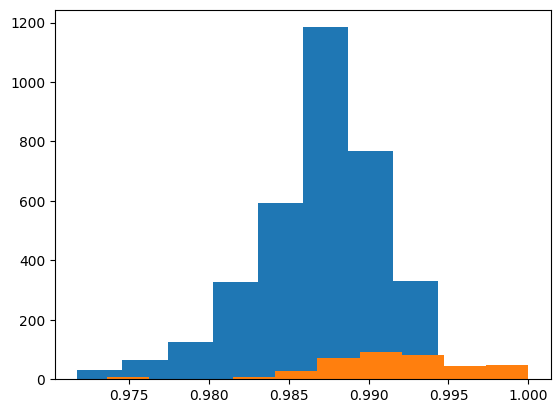

In [11]:
index0 = np.where(np.array(new_labels) == 0)
index1 = np.where(np.array(new_labels) == 1)

cos_list = np.array(cos_list)

plt.hist(cos_list[index0])
plt.hist(cos_list[index1])
plt.show()

In [12]:
import IPython.display as ipd


audio_file_path = 'Vasenkov/one_dictor_my/7/record_out(7).wav'
audio_file_path = audio_file_path[9:]
print(audio_file_path)
ipd.Audio(audio_file_path)

one_dictor_my/7/record_out(7).wav


ValueError: rate must be specified when data is a numpy array or list of audio samples.

In [ ]:
for i in lst:
    for j in lst:
        emb1 = torch.FloatTensor(i.tokens)
        emb2 = torch.FloatTensor(j.tokens)
        trim_tensor1 = whisper.pad_or_trim(emb1,length=3000)
        trim_tensor2 = whisper.pad_or_trim(emb2,length=3000)
        

In [43]:
lst_emb[0][0][:30]

tensor([5.0364e+04, 8.5670e+03, 3.6050e+03, 1.0442e+04, 4.2510e+03, 1.0250e+03,
        4.4477e+04, 8.0500e+02, 2.4498e+04, 6.9800e+02, 2.4051e+04, 4.4330e+03,
        2.2090e+03, 2.8010e+03, 2.6510e+04, 5.6800e+02, 3.8427e+04, 8.2540e+03,
        5.0649e+04, 5.0649e+04, 7.7600e+02, 3.6847e+04, 1.1350e+03, 8.0500e+02,
        1.3000e+01, 5.0712e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

In [8]:
t.shape

torch.Size([1, 1, 768])

In [16]:
E = nn.Embedding(51000,  128)

In [17]:
et = E(t.int())
et.shape

torch.Size([1, 3000, 128])

In [14]:
C = nn.Conv1d(128, 4, 11)
ct = C(torch.tensor(et.detach().numpy().transpose( [0, 2, 1])))
ct.shape

torch.Size([1, 4, 2990])

In [18]:
C = nn.Conv1d(3000, 4, 5, stride=1, padding=2)
ct = C(et)
ct.shape

torch.Size([1, 4, 128])

In [19]:
C2 = nn.Conv1d(4, 1, 5, stride=1, padding=2)
ct2 = C2(ct)
ct2.shape

#размерность x на выходе 1 1 768


torch.Size([1, 1, 128])

In [40]:
class EmbDataset(data.Dataset):
    def __init__(self, path):
        self.path = path        
        self.embeddings, self.labels = read_data_from_csv(self.path)
    
    def __getitem__(self, item):
        # !!! СДЕЛАТЬ ЧТОБЫ БРАЛОСЬ ИТЕРАТИВНО, А НЕ ВСЁ СРАЗУ
        # embeddings, labels = read_data_from_csv(self.path)
        print(item)
        label = self.labels[item]
        label = torch.tensor(label) 
        t = self.embeddings[item]
        
        # E = nn.Embedding(51000,  128)
        # print(t)
        # et = E(t.int())

        # C = nn.Conv1d(3000, 4, 5, stride=1, padding=2)
        # ct = C(et)
        # C2 = nn.Conv1d(4, 1, 5, stride=1, padding=2)
        # ct2 = C2(ct)
        
        # label = torch.tensor(self.labels[item])        
        return t, label
                

    def __len__(self):
        return len(self.embeddings)


d_train = EmbDataset("embeddings.csv")
train_data = data.DataLoader(d_train, batch_size=6, shuffle=True)

# it = iter(train_data)
# x, y = next(it)

### Триплеты

In [42]:
from pytorch_metric_learning import losses
from torch import nn
from random import randint
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.miners import TripletMarginMiner


class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)

class LinearClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # self.embedding = nn.Embedding(input_dim, 128)
        # self.conv = nn.Conv1d()
        self.linear = nn.Linear(input_dim, 128)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))


cosine_distance = CosineSimilarity()
model = LinearClassifier(768)
loss_func = losses.TripletMarginLoss(distance=cosine_distance)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model.train()

for i, (data, label) in enumerate(train_data):
    data = data.to(dtype=torch.float32)
    print(data.shape)
    optimizer.zero_grad()
    # print(data.dtype)
    embeddings = model(data).squeeze()
    # print(embeddings.shape, label)
    loss = loss_func(embeddings, label)
    loss.backward()
    optimizer.step()
    
    print(f'Epoch {i+1}/{100}, Loss: {loss.item():.4f}')

# for epoch in range(100):
#     k = randint(0, total-1)
#     optimizer.zero_grad()
#     outputs = model(X)
#     loss = criterion(outputs.squeeze(), y.float())
#     loss.backward()
#     optimizer.step()
#     print(f'Epoch {epoch+1}/{100}, Loss: {loss.item():.4f}')


0
39
23
1
22
42
torch.Size([6, 1, 1, 768])
Epoch 1/100, Loss: 0.0445
8
27
36
32
34
37
torch.Size([6, 1, 1, 768])
Epoch 2/100, Loss: 0.0487
43
14
41
11
10
33
torch.Size([6, 1, 1, 768])
Epoch 3/100, Loss: 0.0481
6
35
24
9
20
21
torch.Size([6, 1, 1, 768])
Epoch 4/100, Loss: 0.0508
40
5
3
18
26
30
torch.Size([6, 1, 1, 768])
Epoch 5/100, Loss: 0.0466
19
17
38
4
28
29
torch.Size([6, 1, 1, 768])
Epoch 6/100, Loss: 0.0473
15
31
16
13
25
2
torch.Size([6, 1, 1, 768])
Epoch 7/100, Loss: 0.0485
7
12
torch.Size([2, 1, 1, 768])
Epoch 8/100, Loss: 0.0000
